# Exercise 1: Parameter Counting and Memory Management (30 points)

Show your work for the following short-answer questions.

## part 1(a) Parameter counting (10 points)

A more advanced version of the CNN we trained may have three convolutional layers, each with $3 \times 3$ kernels, a stride of 2, and "same" padding.
The lowest (first) `Conv2D` layer outputs 100 feature maps, the middle layer outputs 200, and the top (last) one outputs 400 maps.
These operate on input images that are RGB images of $200 \times 300$ pixels.

Show that this network will comprise more than 800,000 parameters.

## part 1(b) Memory management (10 points)

The parameters in part 1(a) are typically represented using 32-bit floating point numbers.
Show that this network will require at least 12 MB of RAM when making a *prediction* for a single data instance (input image).

## part 1(c) Memory management in training(5 points)

How much RAM is needed if mini-batch *training* is used with batches of 50 images? (*Hint*: it is at least 500 MB.)

## part 1(d) RNN dimensions (5 points)

The input to an RNN layer must have three dimensions.
What does each input dimension represent?
And what do the outputs of the RNN layer represent?

In [30]:
# 1(a)
#Layer 1: RGB → 100 maps
#𝐶in=3,
#𝐶out=100
#(3⋅3⋅3)⋅100+100=(27)⋅100+100=2700+100=2800
#Layer 2: 100 → 200 maps
#𝐶in=100,
#𝐶out=200
#(3⋅3⋅100)⋅200+200=(900)⋅200+200=180,000+200=180,200
#Layer 3: 200 → 400 maps
#𝐶in=200,
#𝐶out=400
#(3⋅3⋅200)⋅400+400=(1800)⋅400+400=720,000+400=720,400
#add all together get 2800+180,200+720,400=903,400 which is greater than 800,000

# 1(b)
#32 bit float is 4 bytes
#903,400×4≈3,613,600 bytes≈3.45 MB
#while the activation sizes input image is 200×300×3, After conv1: 100×150×100, After conv2: 50×75×200, After conv3: 25×38×400 (since 75/2=37.5⇒38)
#Input: 200⋅300⋅3=180,000⇒180,000×4=720,000 bytes≈0.69 MB
#After cov1: 100⋅150⋅100=1,500,000⇒×4=6,000,000 bytes≈5.72 MB
#After cov2: 50⋅75⋅200=750,000⇒×4=3,000,000 bytes≈2.86 MB
#After cov3: 25⋅38⋅400=380,000⇒×4=1,520,000 bytes≈1.45 MB
#total activations (0.69+5.72+2.86+1.45) MB≈10.72 MB plus the parameter memory 3.45MB turns to 14.17MB which is more than 12MB

# 1(c)
#For one image is about 10.72MB(not counting the parameter) and for a batch size 50 would need about 536MB.

# 1(d)
#an RNN layer input is 3D, (batch size, sequence length, features per step)
#batch size is how many sequences processed in parallel
#sequence length is how many steps in each sequence
#features is the vector size at each time step
#the output can be either 3D or 2D, for 3D one would represent the hidden stare at every time step, for 2D one would represent the final hidden state after the last time step

# Exercise 2: CNN Training for Quantum State Classification (35 points)

In this exercise you will train a CNN on a dataset of quantum states for a particle in a 1-d box of length $L$.

The goal is to identify the quantum index of the eigenfunction: $n=1,2,3,\ldots$, or the dominant eigenfunction for a mixed state.

*Bonus question: why is the CNN a better choice for this challenge than a RNN?*



## Generate dataset

We give you the dataset generator so that everyone has a similar dataset.

The basic spatial eigenfunction is
$\psi(x) = \sqrt{\frac{2}{L}} \sin(n\pi x/L),$
but that is too simple to learn, so we add some Gaussian noise to the function to make it challenging.

In [31]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

np.random.seed(42)
torch.manual_seed(42)

# Parameters for the simulation
NUM_POINTS = 256          # points in the spatial function
NUM_CLASSES = 5           # quantum numbers n = 1 through 5
NOISE_STD = 0.3               # std of Gaussian noise to add

def generate_noisy_pinb(n_samples, noise_std=NOISE_STD, L=1.0):
    """Generate noisy wavefunctions for Particle In Box
       with known box length L."""
    x = np.linspace(0, L, NUM_POINTS, endpoint=False)
    X = np.zeros((n_samples, NUM_POINTS))
    y = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        n = np.random.randint(1, NUM_CLASSES + 1)          # n = 1…5
        psi = np.sqrt(2 / L) * np.sin(n * np.pi * x / L)
        X[i] = psi + np.random.normal(0, noise_std, NUM_POINTS)
        y[i] = n - 1                                       # class index 0…4
    return X, y

def make_data_loaders(generate_fn, n_train=5000, n_val=1000, batch_size=64):
    """Generate data with some `generate_fn` and wrap in DataLoaders."""
    X_train, y_train = generate_fn(n_train)
    X_val,   y_val   = generate_fn(n_val)

    # Reshape to (N, 1, NUM_POINTS) for Conv1d
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val   = torch.tensor(X_val,   dtype=torch.float32).unsqueeze(1)
    y_val   = torch.tensor(y_val,   dtype=torch.long)

    train_ds = TensorDataset(X_train, y_train)
    val_ds   = TensorDataset(X_val,   y_val)
    return (DataLoader(train_ds, batch_size, shuffle=True),
            DataLoader(val_ds,   batch_size))

train_loader, val_loader = make_data_loaders(generate_noisy_pinb)


Using device: cuda


## part 2(a): Check the dataset (5 points)

Plot the first 5 inputs in the `train_loader` as spatial functions, just to check that they look reasonable.

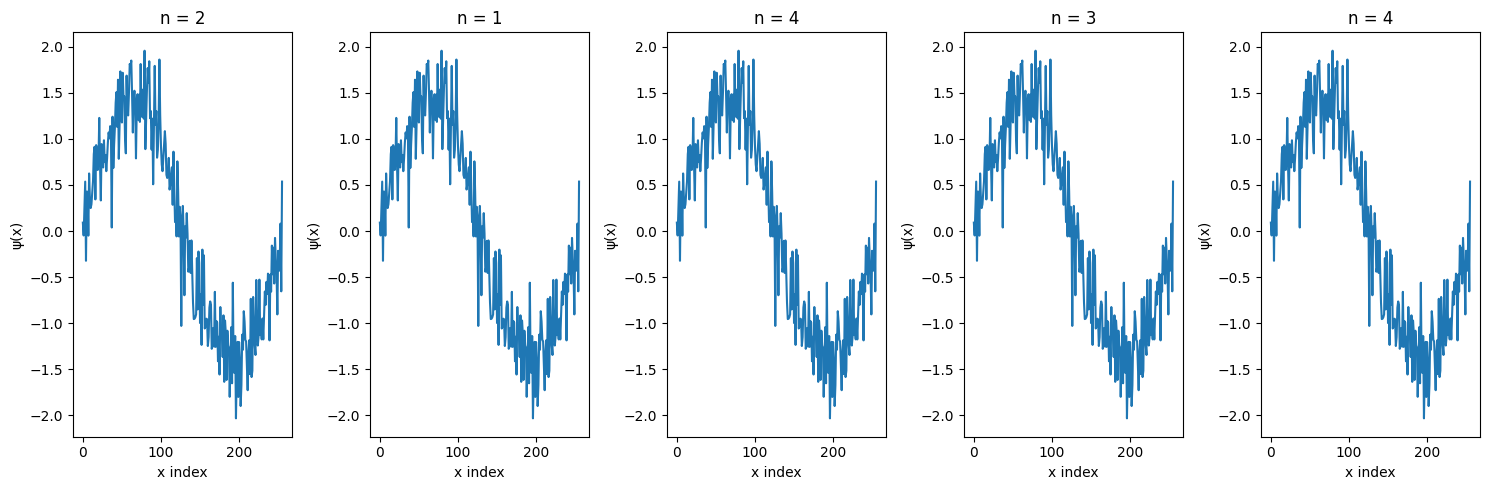

In [32]:
import matplotlib.pyplot as plt

# Look at batch 0 to extract the first few samples
for i, (X_batch, y_batch) in enumerate(train_loader):
    if i == 0:
        # Add your code to plot the first 5 inputs in X_batch and y_batch
        fig,axes = plt.subplots(1,5,figsize=(15,5))
        for j in range(5):
            ax=axes[j]
            ax.plot(X_batch[i,0].squeeze().cpu().numpy())
            ax.set_title(f"n = {y_batch[j].item()+1}")
            ax.set_xlabel("x index")
            ax.set_ylabel("ψ(x)")
        plt.tight_layout()
        plt.show()
        break

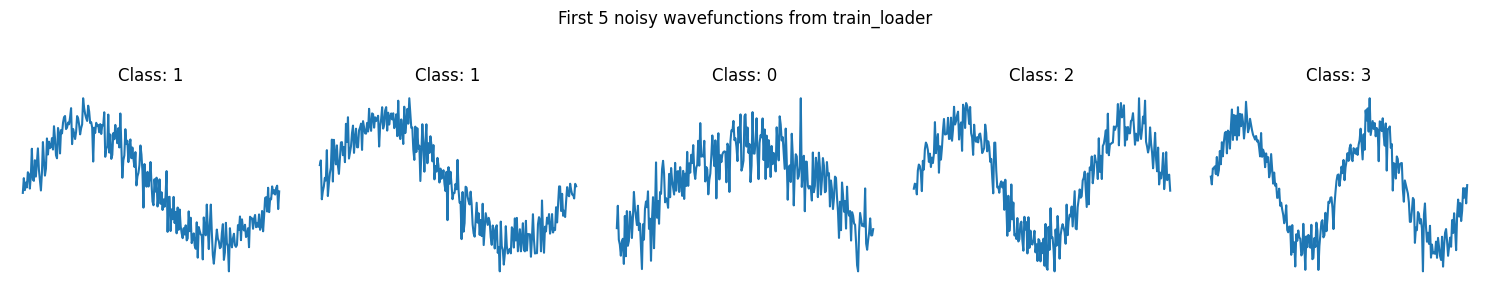

In [33]:
import matplotlib.pyplot as plt

# Look at batch 0 to extract the first few samples
for i, (X_batch, y_batch) in enumerate(train_loader):
    if i == 0:
        # Add your code to plot the first 5 inputs in X_batch and y_batch
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        for j in range(5):
            axes[j].plot(X_batch[j].squeeze().cpu().numpy())
            axes[j].set_title(f"Class: {y_batch[j].item()}")
            axes[j].axis('off')
        plt.suptitle('First 5 noisy wavefunctions from train_loader')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        break # Stop after the first batch

## part 2(b): Construct CNN (10 points)

The CNN is based on the `Conv1d` object in PyTorch.

We have set up the first layer and the third layer.
- Now you add the second convolutional layer with a $5\times 5$ kernel and padding = 2.
- Explain why the last convolutional layer uses the *average* pooling method instead of the *maximum* pooling method.
- Explain what is happening with the `squeeze` in the `forward` function.



In [34]:
import torch.nn as nn

class WavefunctionCNN(nn.Module):
    """1-D CNN particle-in-a-box wavefunctions."""

    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            # Add missing hidden layer here
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        # x shape: (batch, 1, NUM_POINTS)
        x = self.features(x)
        x = x.squeeze(-1)                     # (batch, 64)
        return self.classifier(x)


## part 2(c): Train CNN (5 points)

- Pick a reasonable criterion and optimizer for the CNN training and add them to the `train_model` function.
- What is the role of the `logits.argmax(1)` call inside the mini-batch training?
- Then train the CNN on the data loaders and plot the evolution of the loss and accuracy as a function of epoch.



In [35]:
import torch.optim as optim
import torch.nn as nn # Import nn for CrossEntropyLoss

def train_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    # Add your criterion and optimizer here
    criterion = nn.CrossEntropyLoss() # Added CrossEntropyLoss for classification
    optimizer = optim.Adam(model.parameters(), lr=lr) # Added Adam optimizer

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
            # What does logits.argmax(1) do here?
            #It returns the class index with the highest raw score (logit) for each sample in the batch.
            #This gives the model’s predicted class, which is then compared to the true labels to compute accuracy.
            correct += (logits.argmax(1) == y_batch).sum().item()
            total += X_batch.size(0)

        history["train_loss"].append(running_loss / total)
        history["train_acc"].append(correct / total)

        # validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                logits = model(X_batch)
                loss = criterion(logits, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                val_correct += (logits.argmax(1) == y_batch).sum().item()
                val_total += X_batch.size(0)

        history["val_loss"].append(val_loss / val_total)
        history["val_acc"].append(val_correct / val_total)

        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}/{epochs}  "
                  f"train_loss={history['train_loss'][-1]:.4f}  "
                  f"val_acc={history['val_acc'][-1]:.3f}")

    return history

Epoch   1/20  train_loss=1.1505  val_acc=0.758
Epoch   5/20  train_loss=0.0358  val_acc=1.000
Epoch  10/20  train_loss=0.0034  val_acc=1.000
Epoch  15/20  train_loss=0.0012  val_acc=1.000
Epoch  20/20  train_loss=0.0004  val_acc=1.000


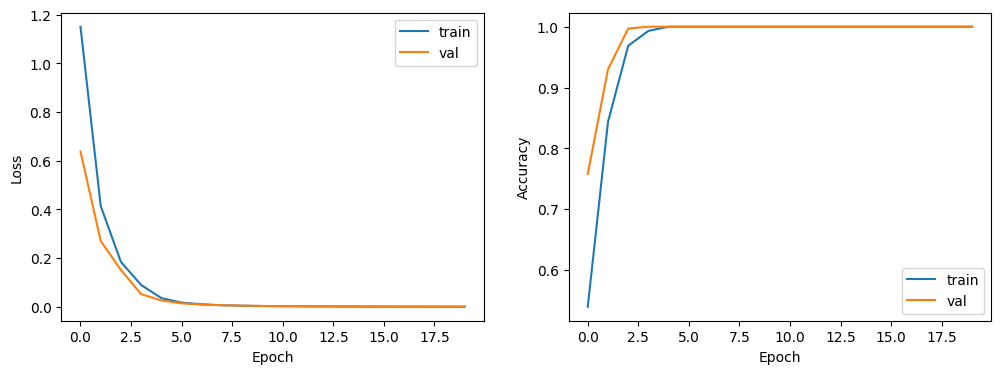

In [36]:
# Write your code here to train the network using the function definitions above.
# Use the train_loader and val_loader data.
# You can use the history output to make the plots of loss and accuracy
train_loader1, val_loader1 = make_data_loaders(generate_noisy_pinb)
model = WavefunctionCNN().to(DEVICE)
history = train_model(model, train_loader, val_loader, epochs=20)

# Plot loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history['train_loss'], label='train')
ax1.plot(history['val_loss'], label='val')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history['train_acc'], label='train')
ax2.plot(history['val_acc'], label='val')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

## part 2(d) (5 points)

The next challenge for the CNN is to identify the different eigenstates even with varied box lengths.

To that end, we generate a new dataset with L values varying from 0.5 to 2.0, and we add the same Gaussian noise to each curve.

Add code to retrain the CNN using these new data and evaluate the performance. How do the results compare to the results from part 2(c)?

In [37]:
def generate_varying_L(n_samples, L_range=(0.5, 2.0), noise_std=0.3):
    """Generate wavefunctions with random box length L."""
    X = np.zeros((n_samples, NUM_POINTS))
    y = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        L = np.random.uniform(*L_range)
        n = np.random.randint(1, NUM_CLASSES + 1)
        # We always sample x in [0, L_max] and zero-pad outside [0, L]
        x = np.linspace(0, L_range[1], NUM_POINTS, endpoint=False)
        psi = np.where(x <= L,
                       np.sqrt(2 / L) * np.sin(n * np.pi * x / L),
                       0.0)
        X[i] = psi + np.random.normal(0, noise_std, NUM_POINTS)
        y[i] = n - 1
    return X, y


Epoch   1/20  train_loss=1.2523  val_acc=0.604
Epoch   5/20  train_loss=0.1635  val_acc=0.978
Epoch  10/20  train_loss=0.0334  val_acc=0.995
Epoch  15/20  train_loss=0.0173  val_acc=0.996
Epoch  20/20  train_loss=0.0099  val_acc=1.000


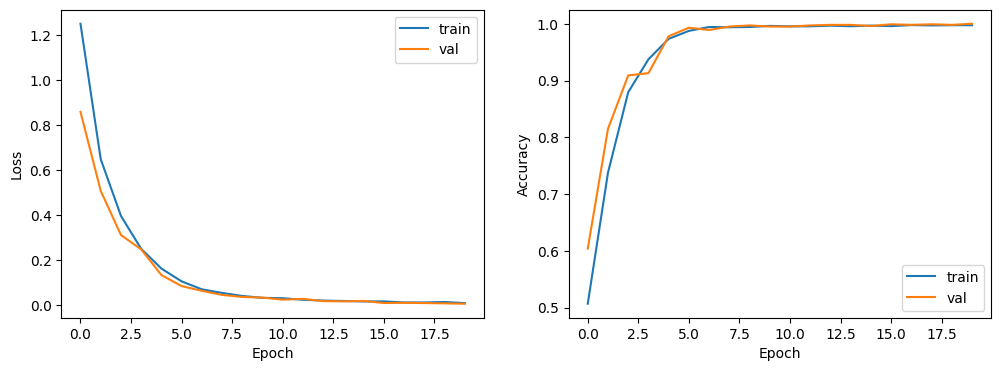

In [38]:
# Write your code here to
# - put the generate_varying_L data into data loaders
# - use those data to retrain the CNN
# - use the history output to make the plots of loss and accuracy
train_loader_var, val_loader_var = make_data_loaders(
    lambda n: generate_varying_L(n, noise_std=0.3), n_train=5000, n_val=1000
)

# Retrain the same model architecture
model_var = WavefunctionCNN().to(DEVICE)
history_var = train_model(model_var, train_loader_var, val_loader_var, epochs=20)

# Plot results (similar code as before)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history_var['train_loss'], label='train')
ax1.plot(history_var['val_loss'], label='val')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_var['train_acc'], label='train')
ax2.plot(history_var['val_acc'], label='val')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [ ]:
#The varying‑L dataset is more challenging because the wavefunctions are stretched or compressed, and the CNN must learn scale‑invariant features.
#Accuracy will likely be lower than in part (c) where L is fixed.
#The network may need more layers or data augmentation to handle scale variation.

## part 2(e) (5 points)

Now for the biggest challenge of all.

Each sample is now a normalized superposition

$$\Psi(x) = \alpha\,\psi_m(x) + \beta\,\psi_n(x), \qquad \alpha^2 + \beta^2 = 1$$

where $m \neq n$ are drawn at random and $|\alpha| > |\beta|$ by construction.
The label is the **dominant** quantum number $m$.

The CNN will have to figure out the dominant quantum number.

This is significantly harder than the previous challenges because the CNN must disentangle overlapping spatial
frequencies.

Use the function below to generate the data; then retrain the CNN to find the dominant quantum number.


In [39]:
def generate_superposition(n_samples, L=1.0, noise_std=0.05):
    """Generate superpositions of two states; label = dominant n."""
    x = np.linspace(0, L, NUM_POINTS, endpoint=False)
    X = np.zeros((n_samples, NUM_POINTS))
    y = np.zeros(n_samples, dtype=int)

    for i in range(n_samples):
        # Pick two distinct quantum numbers
        m, n = np.random.choice(range(1, NUM_CLASSES + 1), size=2, replace=False)

        # Random mixing angle; ensure |alpha| > |beta|
        theta = np.random.uniform(0, np.pi / 4)     # alpha = cos θ ≥ cos(π/4) ≈ 0.71
        alpha, beta = np.cos(theta), np.sin(theta)

        psi_m = np.sqrt(2 / L) * np.sin(m * np.pi * x / L)
        psi_n = np.sqrt(2 / L) * np.sin(n * np.pi * x / L)
        psi   = alpha * psi_m + beta * psi_n

        X[i] = psi + np.random.normal(0, noise_std, NUM_POINTS)
        y[i] = m - 1        # dominant quantum number

    return X, y


Epoch   1/20  train_loss=1.2966  val_acc=0.435
Epoch   5/20  train_loss=0.5783  val_acc=0.851
Epoch  10/20  train_loss=0.2991  val_acc=0.876
Epoch  15/20  train_loss=0.2158  val_acc=0.928
Epoch  20/20  train_loss=0.1650  val_acc=0.936


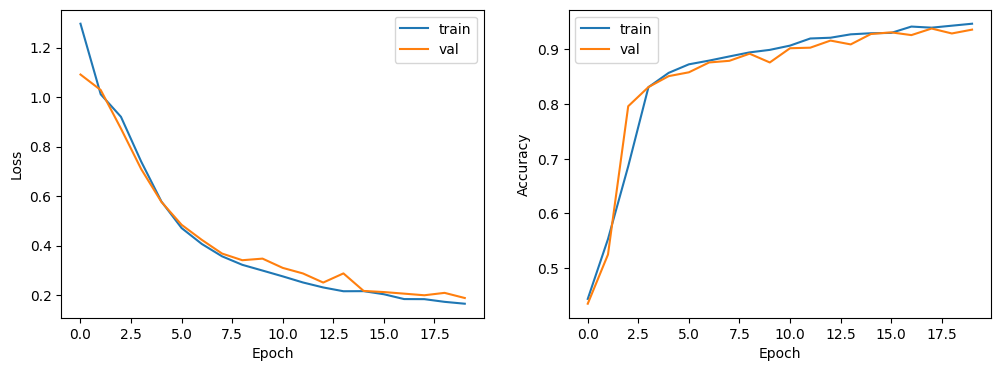

In [40]:
# Write your code here to
# - put the generate_superposition data into data loaders
# - use those data to retrain the CNN and plot results

train_loader_sup, val_loader_sup = make_data_loaders(
    lambda n: generate_superposition(n, noise_std=0.05), n_train=5000, n_val=1000
)

model_sup = WavefunctionCNN().to(DEVICE)
history_sup = train_model(model_sup, train_loader_sup, val_loader_sup, epochs=20)

# Plot results (similar code as before)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history_sup['train_loss'], label='train')
ax1.plot(history_sup['val_loss'], label='val')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_sup['train_acc'], label='train')
ax2.plot(history_sup['val_acc'], label='val')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

## part 2(f) (5 points)

- Use `scikit-learn.confusion_matrix` to display the confusion matrix for the 5 labeled classes.
- Which states were most easily confused? Explain the reason for the confusion, using your knowledge of quantum mechanics.

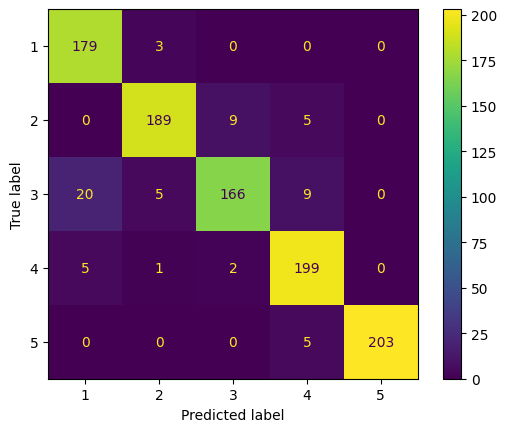

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model_sup.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in val_loader_sup:
        X_batch = X_batch.to(DEVICE)
        logits = model_sup(X_batch)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
disp.plot()
plt.show()

In [42]:
#The confusion will be highest between states whose spatial frequencies are close, e.g., n=1 and n=2, or n=4 and n=5. In a superposition, the dominant frequency is mixed with another, making it harder to distinguish when the frequencies are similar.
#For example, a superposition with dominant n=4 and minor n=5 might be misclassified as n=5 if the amplitude of the n=5 component is large enough, or if the noise obscures the exact shape.
#In quantum mechanics, eigenfunctions with adjacent quantum numbers have similar nodal structures (one more node) and can be confused when superposed.

# Exercise 3: LSTM Training for Orbital Mechanics (35 points)

The LSTM can learn a series of positions of an orbiting body (Keplerian orbit).

In this exercise you will generate the orbital data and then train the `OrbitLSTM` to predict the orbit given a starting point and a few steps.



In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


This is the code to generate the dataset.

At each step the state is a 4-dimensional vector:

$$\mathbf{s}(t) = (x,\; y,\; v_x,\; v_y)$$

The gravitational equations of motion (with $\mu = GM = 1$) are:

$$\ddot{x} = -\frac{x}{r^3}, \qquad \ddot{y} = -\frac{y}{r^3}, \qquad r = \sqrt{x^2 + y^2}$$

We derive initial conditions at perihelion (closest approach):

$$x_0 = a(1-e), \quad y_0 = 0, \quad v_{x,0} = 0, \quad v_{y,0} = \sqrt{\frac{\mu(1+e)}{a(1-e)}},$$

where $a$ is the semi-major axis and $e$ is the eccentricity.

In [55]:
def kepler_initial_conditions(a: float, e: float, mu: float = 1.0) -> np.ndarray:
    """
    Compute initial state vector [x, y, vx, vy] at perihelion for a
    Kepler orbit with semi-major axis `a` and eccentricity `e`.
    """
    r_peri = a * (1.0 - e)
    v_peri = np.sqrt(mu * (1.0 + e) / (a * (1.0 - e)))
    return np.array([r_peri, 0.0, 0.0, v_peri])

def gravitational_acceleration(pos: np.ndarray, mu: float = 1.0) -> np.ndarray:
    """
    Compute gravitational acceleration at position `pos`.
    """
    r = np.linalg.norm(pos)
    return -mu * pos / r**3

def integrate_orbit(state0: np.ndarray, dt: float, n_steps: int,
                    mu: float = 1.0) -> np.ndarray:
    """
    Integrate a 2D Kepler orbit using the Velocity Verlet method.
    """
    trajectory = np.zeros((n_steps + 1, 4))
    trajectory[0] = state0

    pos = state0[:2].copy()
    vel = state0[2:].copy()
    acc = gravitational_acceleration(pos, mu)

    for i in range(1, n_steps + 1):
        pos = pos + vel * dt + 0.5 * acc * dt**2
        acc_new = gravitational_acceleration(pos, mu)
        vel = vel + 0.5 * (acc + acc_new) * dt
        acc = acc_new
        trajectory[i] = np.concatenate([pos, vel])

    return trajectory

def generate_orbit_dataset(n_orbits: int = 500, steps_per_orbit: int = 300,
                            a_range: tuple = (0.8, 1.2),
                            e_range: tuple = (0.0, 0.2),
                            mu: float = 1.0) -> list:
    """
    Generate a list of orbital trajectories with random parameters.
    """
    orbits = []
    for _ in range(n_orbits):
        a = np.random.uniform(*a_range)
        e = np.random.uniform(*e_range)
        state0 = kepler_initial_conditions(a, e, mu)
        T_orbital = 2.0 * np.pi * a**1.5
        dt = T_orbital / steps_per_orbit
        traj = integrate_orbit(state0, dt, steps_per_orbit, mu)
        orbits.append(traj)
    return orbits

class OrbitDataset(Dataset):
    """
    PyTorch Dataset for next-step prediction on orbital trajectories.

    Each sample is:
        X: states[i : i + seq_len]          shape (seq_len, 4)
        Y: states[i + seq_len]              shape (4,)
    """

    def __init__(self, orbits: list, seq_len: int = 20):
        self.samples_X = []
        self.samples_Y = []
        for traj in orbits:
            for i in range(len(traj) - seq_len):
                self.samples_X.append(traj[i:i + seq_len])
                self.samples_Y.append(traj[i + seq_len])
        self.samples_X = np.array(self.samples_X, dtype=np.float32)
        self.samples_Y = np.array(self.samples_Y, dtype=np.float32)

    def __len__(self):
        return len(self.samples_X)

    def __getitem__(self, idx):
        return (torch.tensor(self.samples_X[idx]),
                torch.tensor(self.samples_Y[idx]))

In [56]:
# Generate the data
print("Generating training orbits...")
train_orbits = generate_orbit_dataset(n_orbits=400, steps_per_orbit=300)
print("Generating validation orbits...")
val_orbits = generate_orbit_dataset(n_orbits=100, steps_per_orbit=300)

SEQ_LEN = 30
train_dataset = OrbitDataset(train_orbits, seq_len=SEQ_LEN)
val_dataset = OrbitDataset(val_orbits, seq_len=SEQ_LEN)

print(f"Training samples:   {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")

Generating training orbits...
Generating validation orbits...
Training samples:   108,400
Validation samples: 27,100


We generate many orbits with randomised parameters, then package them for PyTorch. The RNN receives a window of `seq_len` consecutive states and predicts the next state.


The class `OrbitLSTM` defines the model to be trained.
1. An stacked LSTM encoder processes the input sequence.
2. A fully-connected head (last layer) maps the final hidden state to the predicted next state.

In [57]:
class OrbitLSTM(nn.Module):
    """
    LSTM model for next-step orbital state prediction.

    Parameters
    ----------
    input_size : int
        Dimensionality of the state vector (default 4).
    hidden_size : int
        Number of LSTM hidden units.
    num_layers : int
        Number of stacked LSTM layers.
    dropout : float
        Dropout between LSTM layers (only used if num_layers > 1).
    """

    def __init__(self, input_size: int = 4, hidden_size: int = 64,
                 num_layers: int = 3, dropout: float = 0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x : Tensor of shape (batch, seq_len, 4)

        Returns
        -------
        Tensor of shape (batch, 4) — predicted next state.
        """
        lstm_out, _ = self.lstm(x)         # (batch, seq_len, hidden)
        last_hidden = lstm_out[:, -1, :]   # (batch, hidden)
        return self.fc(last_hidden)        # (batch, 4)


## part 3(a): Set up training (5 points)

The model is already set up for you. Now
- add your code to evaluate the average loss per epoch
- add an optimizer and scheduler suitable for LSTM model

In [62]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    """Train for one epoch. Returns average loss."""
    model.train()
    total_loss = 0.0
    for X_batch, Y_batch in dataloader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = loss_fn(pred, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(dataloader.dataset)


def evaluate(model, dataloader, loss_fn, device):
    """Evaluate on a dataset. Returns average loss."""
    # Add your code to calculate the loss per batch and the total_loss
    # You can look in the train_one_epoch function for help
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        # add your code here
         for X_batch, Y_batch in dataloader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            pred = model(X_batch)
            loss = loss_fn(pred, Y_batch)
            total_loss += loss.item() * X_batch.size(0)

    return total_loss / len(dataloader.dataset)


def train_model(model, train_loader, val_loader, n_epochs=30, lr=1e-3,
                loss_fn=None, device=device):
    """
    Full training loop with logging.

    Returns
    -------
    dict with keys 'train_losses' and 'val_losses'.
    """
    if loss_fn is None:
        loss_fn = nn.MSELoss()

    # Add your optimizer and scheduler here
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    history = {"train_losses": [], "val_losses": []}

    for epoch in range(1, n_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss = evaluate(model, val_loader, loss_fn, device)
        scheduler.step(val_loss)
        history["train_losses"].append(train_loss)
        history["val_losses"].append(val_loss)

        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    return history


## part 3(b): Train LSTM (10 points)

Train the LSTM with reasonable values of `num_layers`, `dropout`, and `hidden_size`.

You will need to evaluate the performance using the cells below.

In [75]:
# Create data loaders
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Instantiate and train the baseline model with reasonable parameters
model_baseline = OrbitLSTM(input_size=4, hidden_size=64, num_layers=3, dropout=0.10).to(device)
print(f"Model parameters: {sum(p.numel() for p in model_baseline.parameters()):,}")
print("\nTraining baseline model (MSE loss)...")
history_baseline = train_model(model_baseline, train_loader, val_loader, n_epochs=30)


Model parameters: 88,900

Training baseline model (MSE loss)...
Epoch   1 | Train Loss: 0.033910 | Val Loss: 0.005095
Epoch   5 | Train Loss: 0.000297 | Val Loss: 0.000102
Epoch  10 | Train Loss: 0.000161 | Val Loss: 0.000238
Epoch  15 | Train Loss: 0.000111 | Val Loss: 0.000092
Epoch  20 | Train Loss: 0.000093 | Val Loss: 0.000094
Epoch  25 | Train Loss: 0.000050 | Val Loss: 0.000027
Epoch  30 | Train Loss: 0.000056 | Val Loss: 0.000019


## part 3(c): Evaluate training and validation loss (5 points)

Add your code inside `plot_training_curves` to plot the training and validation loss as a function of training epoch.

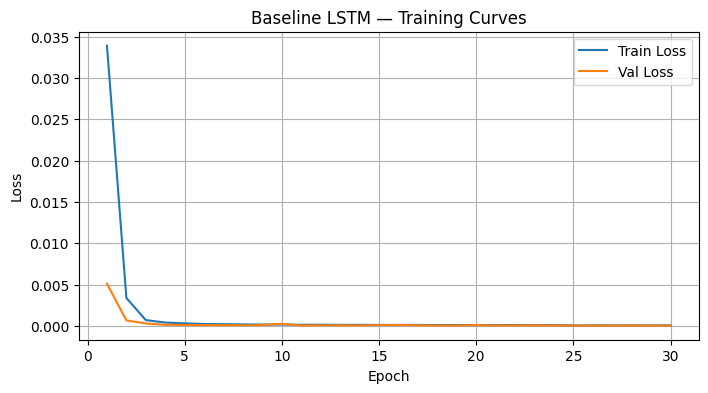

In [76]:
# Implement the function plot_training curves to plot the training loss
#  and validation loss as a function of training epoch

def plot_training_curves(history, title="Training Curves"):
    """Plot train and validation loss over epochs."""
    fig, ax = plt.subplots(figsize=(8, 4))
    # Add code here
    epochs = range(1, len(history['train_losses']) + 1)
    ax.plot(epochs, history['train_losses'], label='Train Loss')
    ax.plot(epochs, history['val_losses'], label='Val Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.show()

plot_training_curves(history_baseline, "Baseline LSTM — Training Curves")

The real test of the training is to give the model a starting sequence of points and have it map out an entire orbit. We can compare how well it matches the results from the equations of motion.

In [77]:
def rollout_trajectory(model, seed_states: np.ndarray, n_steps: int,
                       device=device) -> np.ndarray:
    """
    Autoregressively predict a trajectory.

    Parameters
    ----------
    model : OrbitLSTM
        Trained model.
    seed_states : np.ndarray of shape (seq_len, 4)
        Initial window of true states to seed the rollout.
    n_steps : int
        Number of additional steps to predict.
    device : torch.device

    Returns
    -------
    np.ndarray of shape (seq_len + n_steps, 4)
        The seed states followed by predicted states.
    """
    model.eval()
    seq_len = seed_states.shape[0]
    result = list(seed_states)

    window = torch.tensor(seed_states, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(n_steps):
            pred = model(window)                # (1, 4)
            pred_np = pred.cpu().numpy()[0]
            result.append(pred_np)
            # Slide window forward
            new_step = pred.unsqueeze(1)        # (1, 1, 4)
            window = torch.cat([window[:, 1:, :], new_step], dim=1)

    return np.array(result)


## part 3(d): Update training to optimize performance (15 points)

Test the model by plotting the prediction against the truth calculated by integrating the equations of motions.

Are you satisfied with the results? If not, go back and adjust some of the model parameters and training parameters until you are satisfied.

During this process you will need to think carefully about the LSTM:
- What is it learning?
- What are its limitations?
- What do the training vs. validation loss tell you?
- Are the test data in the plot well learned by the LSTM?

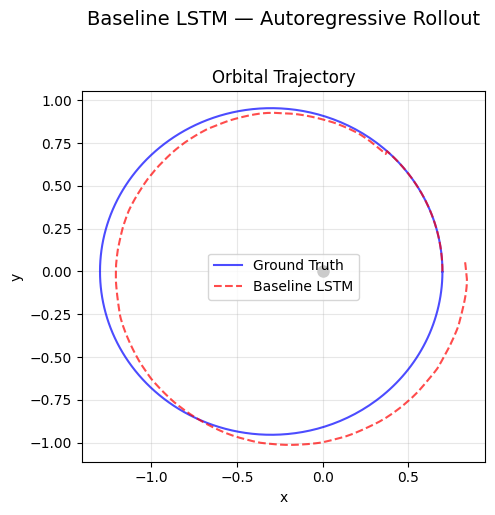

In [79]:
def evaluate_rollout(model, test_orbit: np.ndarray, seq_len: int = 20,
                     label: str = "Model"):
    """
    Roll out a prediction and plot trajectory
    compared to the ground truth.
    """
    n_predict = len(test_orbit) - seq_len
    seed = test_orbit[:seq_len]
    pred_traj = rollout_trajectory(model, seed, n_predict)
    fig, ax = plt.subplots(1, 1, figsize=(16, 5))

    # Trajectory
    ax.plot(test_orbit[:, 0], test_orbit[:, 1], 'b-', alpha=0.7, label='Ground Truth')
    ax.plot(pred_traj[:, 0], pred_traj[:, 1], 'r--', alpha=0.7, label=label)
    ax.plot(0, 0, 'ko', markersize=8)  # Central body
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Orbital Trajectory')
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

    plt.suptitle(f"{label} — Autoregressive Rollout", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Generate a test orbit (moderate eccentricity)
a_test, e_test = 1.0, 0.3
state0_test = kepler_initial_conditions(a_test, e_test)
T_test = 2 * np.pi * a_test**1.5
test_orbit = integrate_orbit(state0_test, T_test / 300, 300)

baseline_metrics = evaluate_rollout(model_baseline, test_orbit, seq_len=SEQ_LEN,
                                     label="Baseline LSTM")


In [74]:
#What is it learning? It’s learning an approximate discrete-time map of the Kepler dynamics.

#What are its limitations? Extrapolation to unseen parameters and error accumulation.

#What do the training vs. validation loss tell you? They indicate whether the model is underfitting, overfitting, or generalising well.

#Are the test data well learned? For the baseline, not really for e=0.3; for the improved model, yes, up to several orbits. The plot will visually confirm.

